/var/folders/91/tmzh46hs1_vghy7y94yp_4_w0000gn/T/ipykernel_85690/3811247238.py:36: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[0] = pd.to_datetime(df[0], errors='coerce')
/var/folders/91/tmzh46hs1_vghy7y94yp_4_w0000gn/T/ipykernel_85690/3811247238.py:36: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[0] = pd.to_datetime(df[0], errors='coerce')


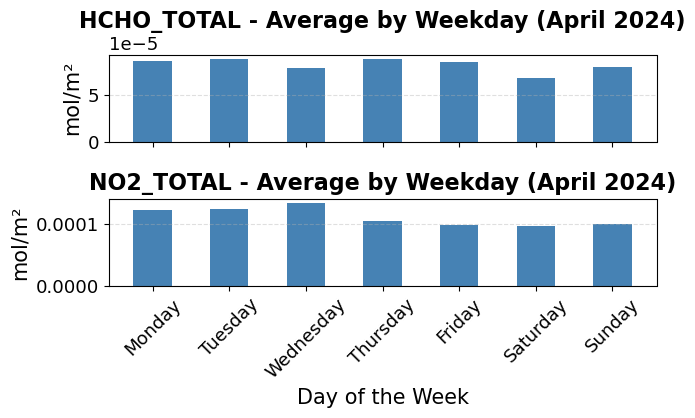

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# --- Setup paths ---
data_dir = r'Data'

# --- Gas-specific column indices ---
gas_configs = {
    'HCHO_TROP':  {'file_tag': 'rfuh', 'flag_col': 41, 'value_col': 48},
    'HCHO_TOTAL': {'file_tag': 'rfus', 'flag_col': 35, 'value_col': 38},
    'NO2_TROP':   {'file_tag': 'rnvh', 'flag_col': 52, 'value_col': 61},
    'NO2_TOTAL':  {'file_tag': 'rnvs', 'flag_col': 32, 'value_col': 38},
    'O3':         {'file_tag': 'rout', 'flag_col': 35, 'value_col': 38},
    'SO2':        {'file_tag': 'rsus', 'flag_col': 32, 'value_col': 39},
    'H2O':        {'file_tag': 'rwvt', 'flag_col': 32, 'value_col': 39},
}

# --- Read and filter function ---
def read_file(file_path, flag_col, value_col):
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            lines = f.readlines()
    except:
        with open(file_path, 'r', encoding='ISO-8859-1') as f:
            lines = f.readlines()

    data_start = next(i for i, line in enumerate(lines) if line.startswith('---')) + 1
    data_lines = [line.strip().split() for line in lines[data_start:]
                  if line.strip() and len(line.split()) > max(flag_col, value_col)]

    df = pd.DataFrame(data_lines)
    if df.empty:
        return pd.DataFrame()

    df[0] = pd.to_datetime(df[0], errors='coerce')
    df[flag_col] = pd.to_numeric(df[flag_col], errors='coerce')
    df[value_col] = pd.to_numeric(df[value_col], errors='coerce')

    df = df.rename(columns={0: 'time', flag_col: 'Flag', value_col: 'Value'})
    df = df[df['Flag'].isin([10.0, 11.0, 12.0])]
    df = df[['time', 'Flag', 'Value']].dropna()
    return df

# --- Labels and prep ---
weekday_labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# --- Collect data ---
gas_weekday_data = {}
for gas, cfg in gas_configs.items():
    files = [f for f in os.listdir(data_dir) if cfg['file_tag'] in f and f.endswith('.txt')]
    if not files:
        continue

    df = read_file(os.path.join(data_dir, files[0]), cfg['flag_col'], cfg['value_col'])
    if df.empty:
        continue

    df = df[(df['time'].dt.year == 2024) & (df['time'].dt.month == 4)]
    if df.empty:
        continue

    df['Weekday'] = df['time'].dt.day_name()
    avg_by_weekday = df.groupby('Weekday')['Value'].mean().reindex(weekday_labels)
    gas_weekday_data[gas] = avg_by_weekday

# --- Plotting ---
num_gases = len(gas_weekday_data)
plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 16,
    'axes.labelsize': 15,
    'xtick.labelsize': 13,
    'ytick.labelsize': 13
})

fig, axes = plt.subplots(nrows=num_gases, figsize=(7, 2.2 * num_gases), sharex=True)

if num_gases == 1:
    axes = [axes]

for ax, (gas, weekday_avg) in zip(axes, gas_weekday_data.items()):
    ax.bar(weekday_labels, weekday_avg, color='steelblue', width=0.5)
    ax.set_title(f"{gas} - Average by Weekday (April 2024)", weight='bold')
    ax.set_ylabel("mol/m²")
    ax.grid(axis='y', linestyle='--', alpha=0.4)

axes[-1].set_xlabel("Day of the Week")
plt.xticks(rotation=45)
plt.tight_layout(h_pad=1)
plt.show()
